In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

sns.set_context("talk", font_scale=1.0)

In [45]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'existing_relevant_combinations.csv'

# Load the dataframe from CSV with comma as delimiter
df = pd.read_csv(file_path, delimiter=',')

In [46]:
# Create set colors for each model to use in graphs
model_names = df["model"].unique().tolist()
base_cmap = sns.color_palette('husl', n_colors=30)
colors = {model: base_cmap[i] for i, model in enumerate(model_names)}

#### BIM/PGD/CosPGD init flow as optimization target -- Kitti

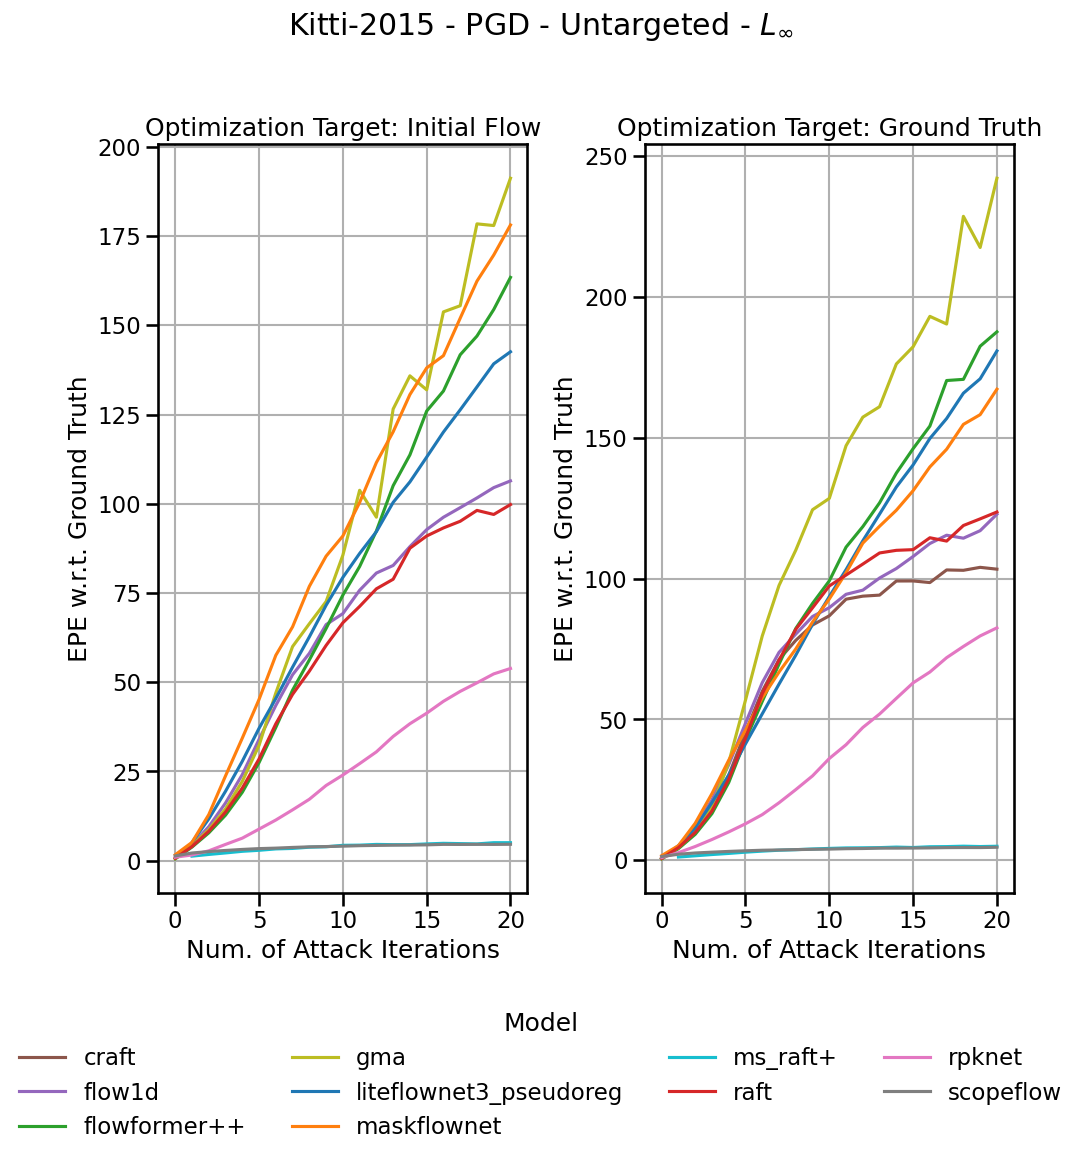

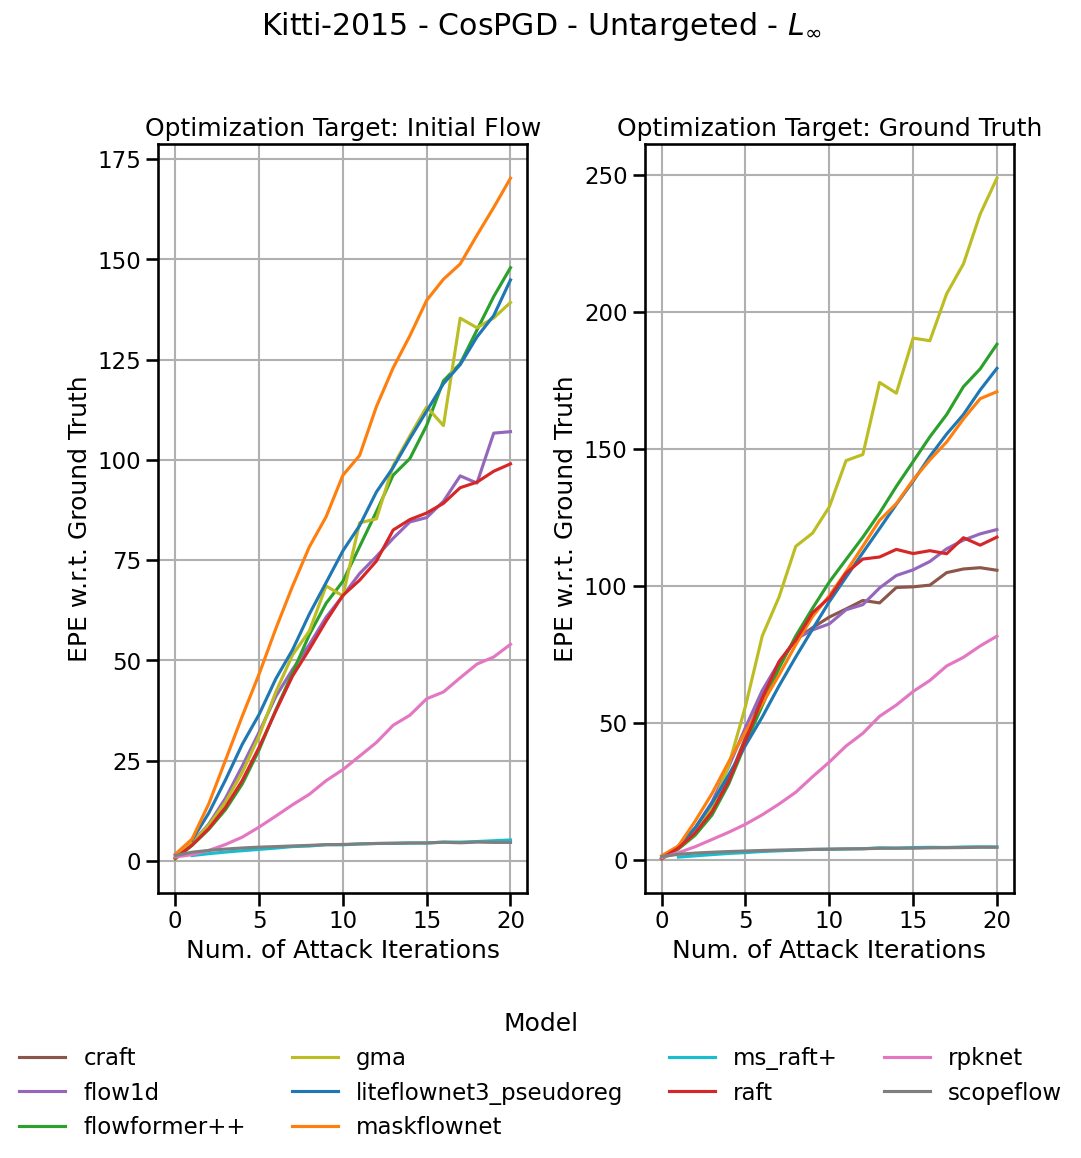

In [47]:
model_list_kitti_top10 = ["liteflownet3_pseudoreg", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]
model_list_sintel_top10 = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]

colors = plt.get_cmap("tab10").colors

# Create a distinct color palette for each model
model_palette_sintel_top10 = {model: color for model, color in zip(model_list_sintel_top10, colors)}
model_palette_kitti_top10 ={model: color for model, color in zip(model_list_kitti_top10, colors)}


def plot(data, title, filename, optim_targets, model_palette):
    num_optim_target = len(optim_targets)
    fig, axes = plt.subplots(1, num_optim_target, figsize=(5 * num_optim_target, 10))
    fig.suptitle(title)

    if num_optim_target == 1:
        axes = [axes]


    # Collect handles and labels for the legend
    handles, labels = [], []

    for ax, optim_target in zip(axes, optim_targets):
        # Filter the data for the current optimization target
        plot_data = data.query(f"optim == '{optim_target}' or epsilon == 0")
        # Create the line plot with consistent color mapping
        sns.lineplot(
            data=plot_data,
            x='iterations_type',
            y='epes',
            hue='model',
            palette=model_palette,  # Apply the predefined color palette
            ax=ax,
            errorbar=None
        )

        # Collect legend handles and labels from each plot
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

        ax.set_title(f"Optimization Target: {optim_target.replace('ground_truth', 'Ground Truth').replace('initial_flow', 'Initial Flow')}")
        ax.set_xlabel('Num. of Attack Iterations')
        ax.set_ylabel('EPE w.r.t. Ground Truth')
        ax.grid(True)

    # Remove individual legends from each subplot
    for ax in axes:
        ax.legend_.remove()

    # Create a unique legend for the entire figure
    unique_handles_labels = dict(zip(labels, handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=4, frameon=False, title='Model')

    # Adjust layout to fit title and legend
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'kitti-2015' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Kitti-2015 - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_kitti_init_flow.png', ["initial_flow", "ground_truth"], model_palette_kitti_top10)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Kitti-2015 - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_kitti_init_flow.png', ["initial_flow", "ground_truth"], model_palette_kitti_top10)


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-clean

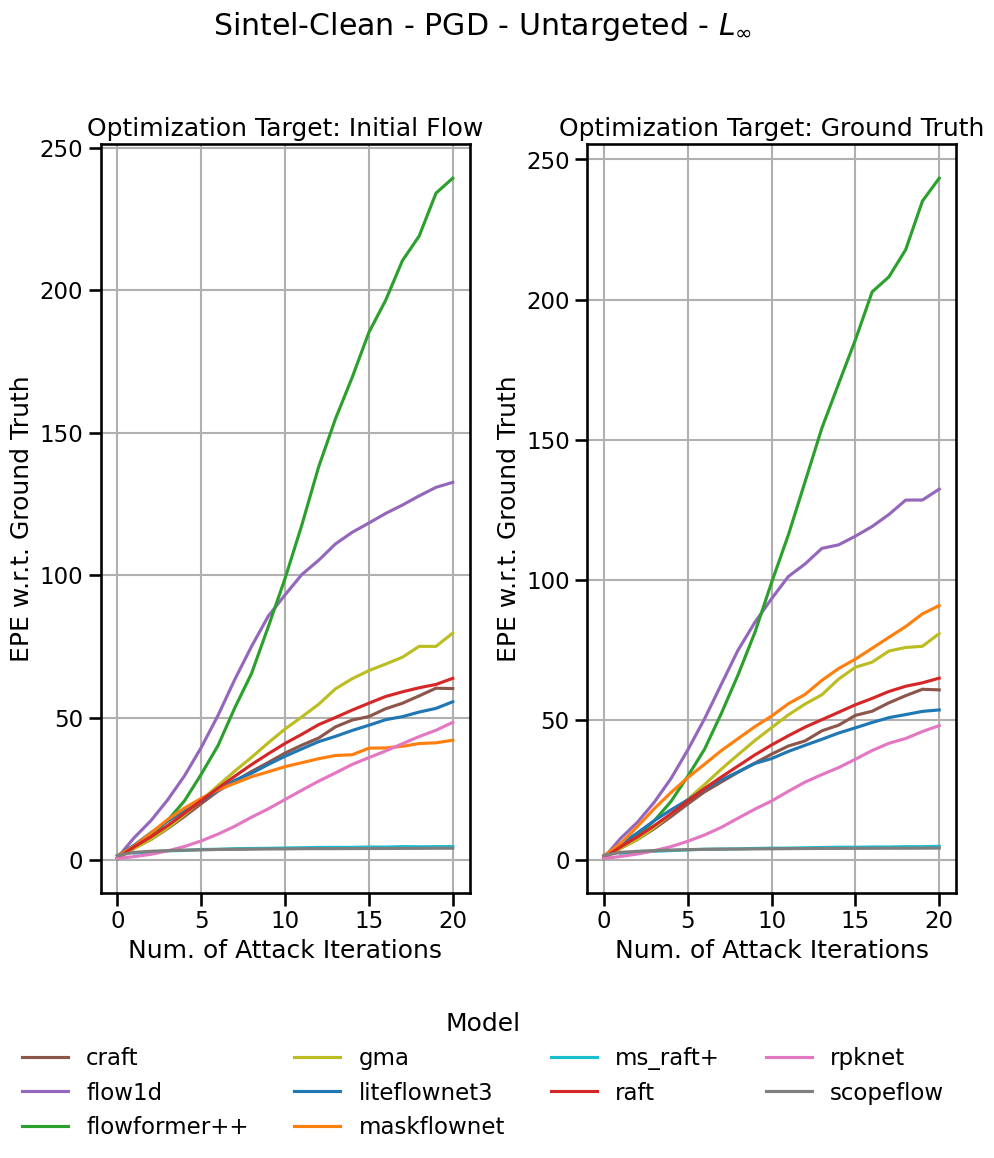

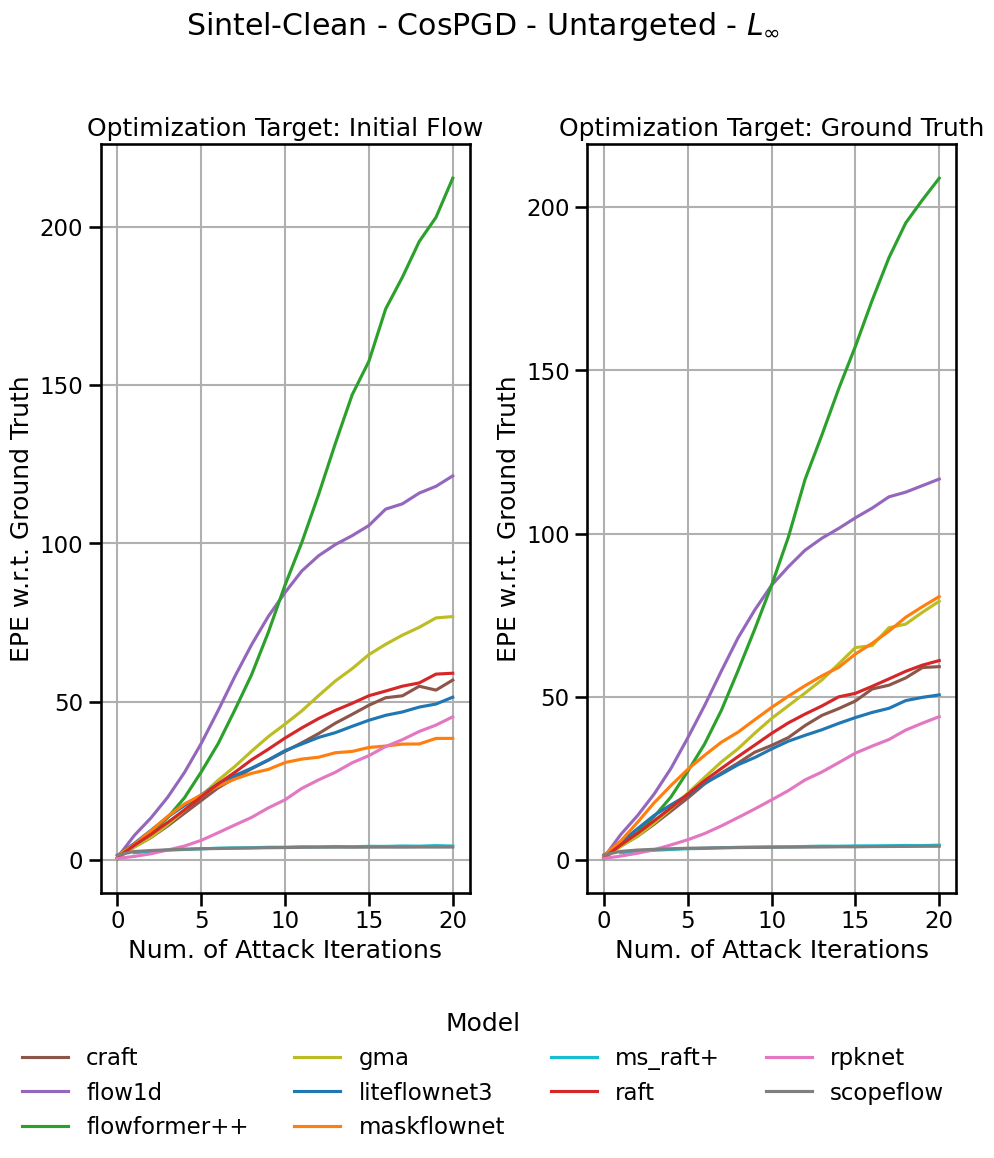

In [48]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-clean' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Clean - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Clean - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-final

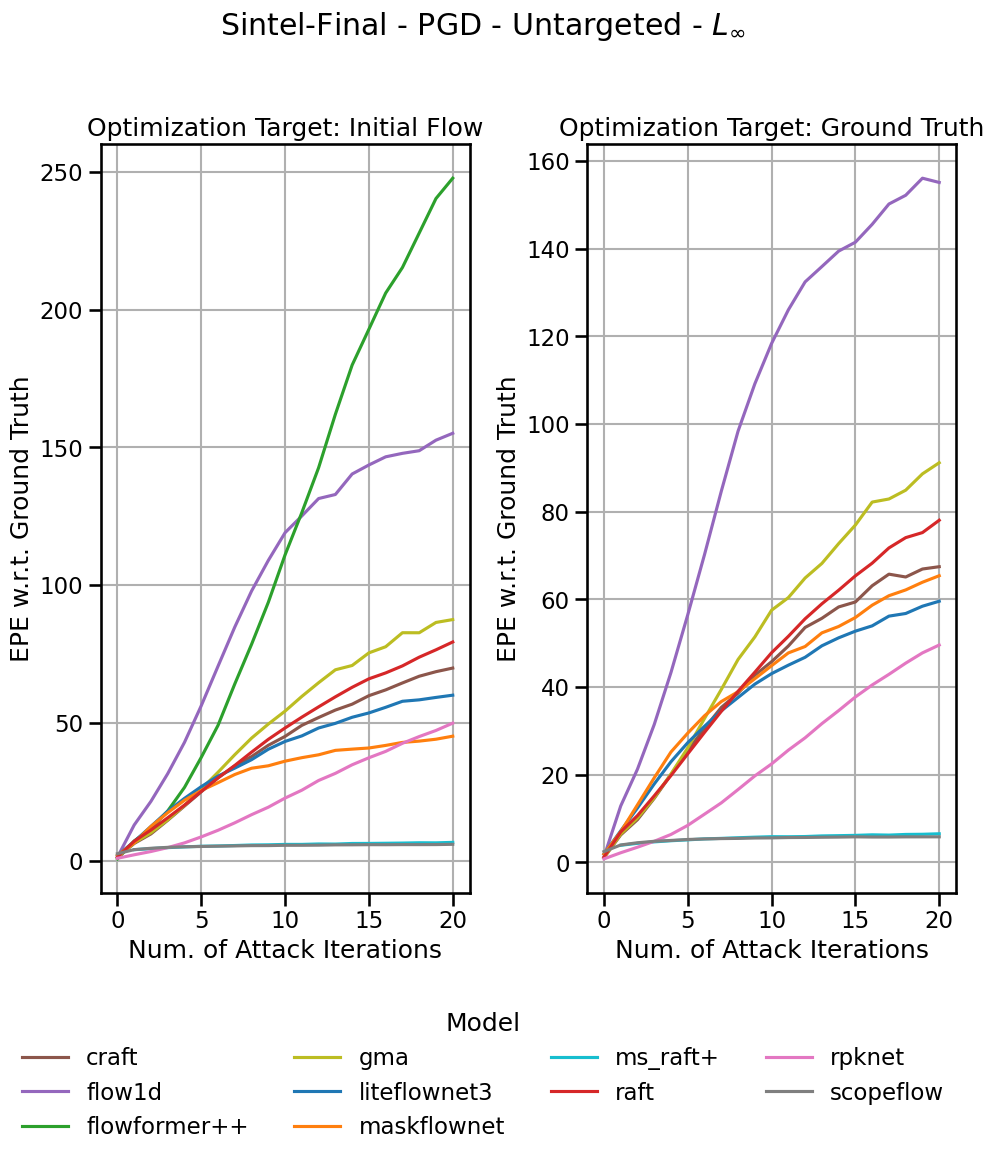

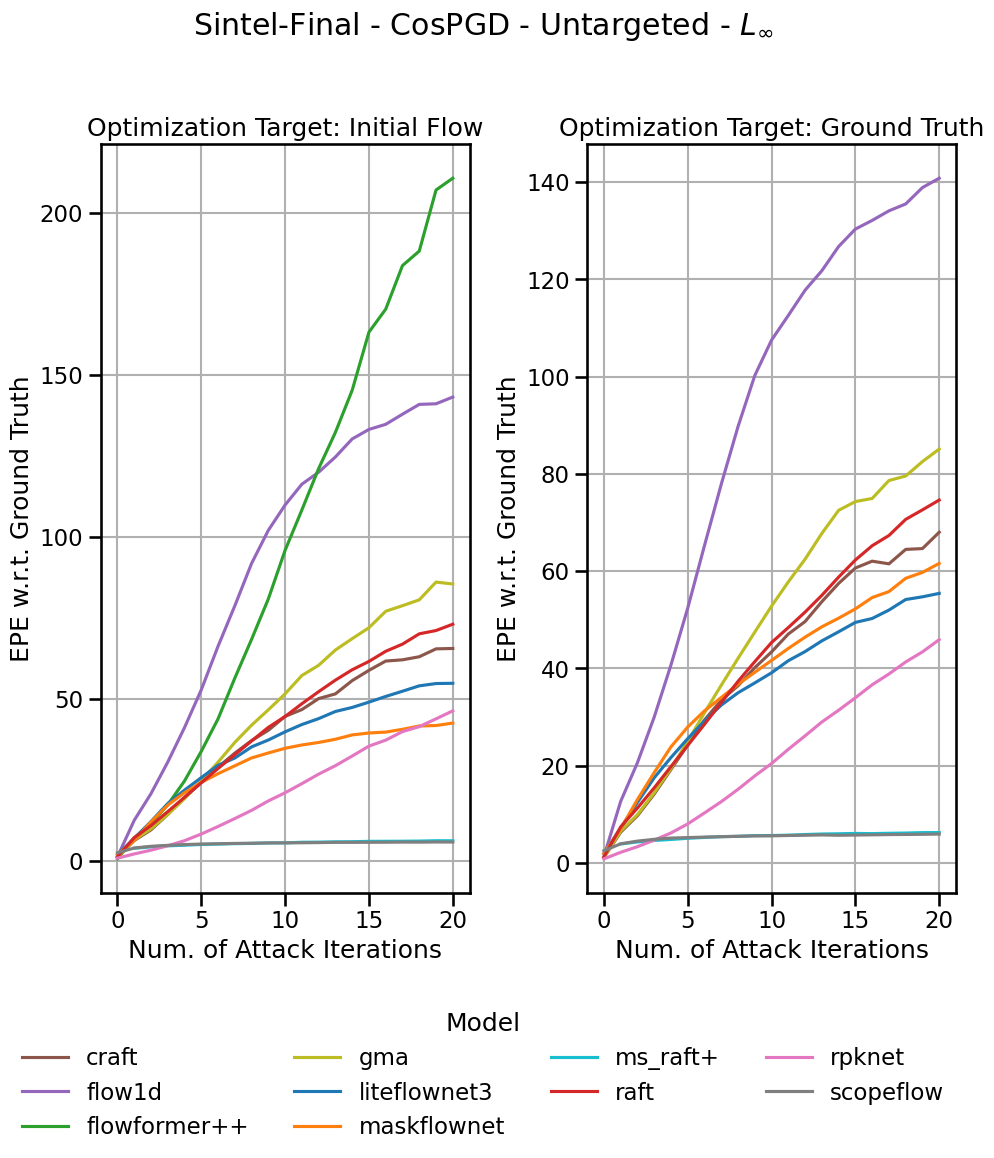

In [49]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-final' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Final - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_final_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot(data_untargeted_inf, r'Sintel-Final - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_final_init_flow.png', ["initial_flow", "ground_truth"], model_palette_sintel_top10)
